# Data Challenge 3

## Download data

In [9]:
#! pip install -q lalsuite
#! pip install -q gwpy
#! pip install -q pycbc
# -- Click "restart runtime" in the runtime menu

# -- download data
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf

# -- for gwpy 
from gwpy.timeseries import TimeSeries
gwpy_strain = TimeSeries.read('challenge3.gwf', channel="H1:CHALLENGE3")

# -- for pycbc
from pycbc import frame
pycbc_strain = frame.read_frame('challenge3.gwf', 'H1:CHALLENGE3')

--2022-05-26 20:22:43--  https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256815066 (245M)
Saving to: ‘challenge3.gwf.2’

challenge3.gwf.2    100%[===================>] 244.92M  17.6MB/s    in 16s     

2022-05-26 20:22:59 (15.7 MB/s) - ‘challenge3.gwf.2’ saved [256815066/256815066]



## Sampling rate and duration

In [10]:
duration = len(gwpy_strain)*gwpy_strain.dt
sampling_rate = 1/gwpy_strain.dt
print("duration = {}".format(duration))
print("sampling rate = {}".format(sampling_rate))

duration = 4096.0 s
sampling rate = 4096.0 1 / s


## Plotting the data

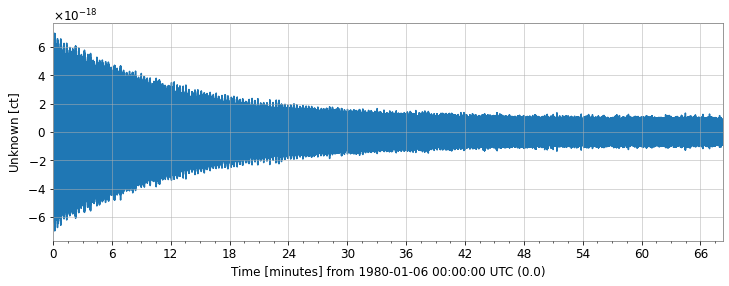

In [11]:
%matplotlib inline
plot = gwpy_strain.plot()

## Q-transform

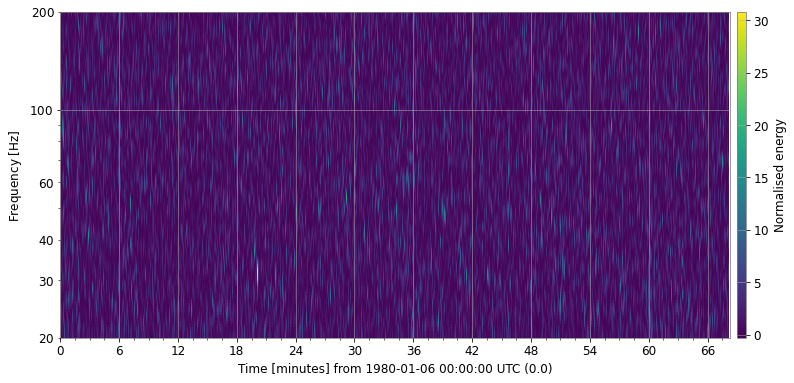

In [12]:
hq = gwpy_strain.q_transform(frange=(20, 200), qrange=(30, 31))
plot_hq = hq.plot()
ax = plot_hq.gca()
ax.set_yscale('log')
#ax.set_xlim(20*60, 21*60-15)
#ax.set_xlim(41*60, 42*60-5)
ax.colorbar(label="Normalised energy")

# Time domain waveform

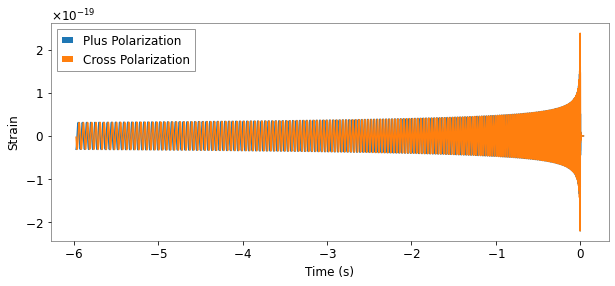

In [13]:
from pycbc.waveform import get_td_waveform
import pylab
%matplotlib inline

sample_delta_t = 1.0/2048

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=sample_delta_t,
                         f_lower=20)

pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()

## Generate the PSD

In [14]:
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation

# Remove the low frequency content and downsample the data to 2048Hz
strain = highpass(pycbc_strain, 15.0)
strain = resample_to_delta_t(strain, sample_delta_t)
# Remove 2 seconds of data from both the beginning and end
conditioned = strain.crop(2, 2)
# We use 16 second samples of our time series in Welch method.
p = conditioned.psd(16)
p = interpolate(p, conditioned.delta_f)
p = inverse_spectrum_truncation(p, int(4 * conditioned.sample_rate), low_frequency_cutoff=20.0)
psd = p

## Matched filtering

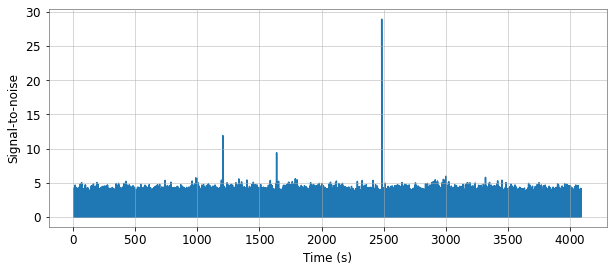

We found a signal at 2483.96728515625s with SNR 28.93008590773068


In [15]:
from pycbc.filter import matched_filter
import numpy

# Resize the vector to match our data
hp.resize(len(conditioned))
hc.resize(len(conditioned))

template_p = hp.cyclic_time_shift(hp.start_time)
template_c = hc.cyclic_time_shift(hc.start_time)

snr_p = matched_filter(template_p, conditioned,psd=psd, low_frequency_cutoff=20)
snr_c = matched_filter(template_c, conditioned,psd=psd, low_frequency_cutoff=20)
snr = snr_p.crop(5, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

## Chi square

In [16]:
from pycbc.vetoes import power_chisq

# The number of bins to use. In principle, this choice is arbitrary. In practice,
# this is empirically tuned.
chisq = {}
nbins = 26
chisq = power_chisq(hp, conditioned, nbins, psd, low_frequency_cutoff=20.0)
chisq = chisq.crop(5, 4)

dof = nbins * 2 - 2
chisq /= dof

### Re-weighting our SNR to help down-weight times that don't fit our signal ###

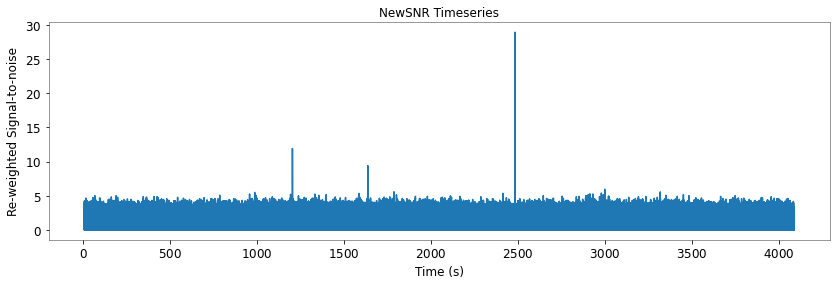

In [17]:
from pycbc.events.ranking import newsnr

# The rho-hat term above is named "newsnr" here
nsnr = newsnr(abs(snr), chisq)

# Plot the new SNR timeseries
pylab.figure(figsize=[14, 4])
pylab.plot(snr.sample_times, nsnr)
pylab.title('NewSNR Timeseries')
pylab.grid()
#pylab.xlim(100,120)
#pylab.ylim(0, 15)
pylab.xlabel('Time (s)')
pylab.ylabel('Re-weighted Signal-to-noise')
pylab.show()

## Matched-filtering code from sample

Looking at file challenge3.gwf with template mass 10 M_sol


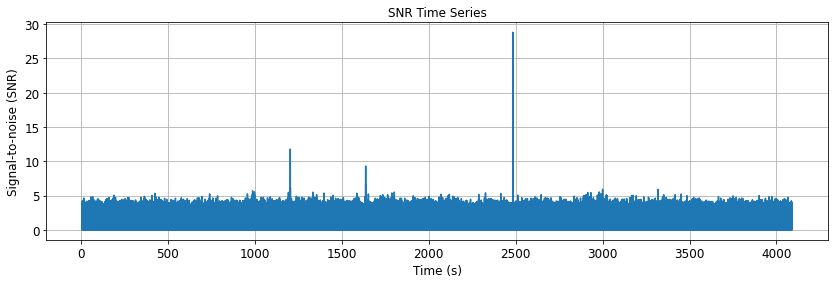

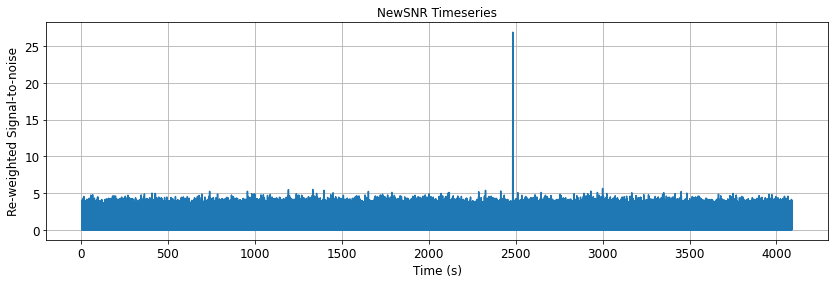

We found a signal at 2483.96875s with (reweighed) SNR 26.870953418426534


In [1]:
from pycbc import frame
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.vetoes import power_chisq
from pycbc.events.ranking import newsnr

import numpy

import pylab
%matplotlib inline

def challenge_matched_filter(file_name,mass):
    print("Looking at file {} with template mass {} M_sol".format(file_name,mass))
    channel_name = "H1:CHALLENGE3"
    #start = 0
    #end = start + 128
    #ts = read_frame(file_name, channel_name, start, end)
    ts = frame.read_frame(file_name, channel_name)
    ts = highpass(ts, 15.0)
    strain_ts = resample_to_delta_t(ts, 1.0/2048)
    conditioned_ts = strain_ts.crop(2, 2)
    psd_ts = conditioned_ts.psd(16)
    psd_ts = interpolate(psd_ts, conditioned_ts.delta_f)
    psd_ts = inverse_spectrum_truncation(psd_ts, int(4 * conditioned_ts.sample_rate),low_frequency_cutoff=15)
    
    hp_x, _ = get_fd_waveform(approximant="IMRPhenomD",
                                mass1=mass, mass2=mass,
                                f_lower=20.0, delta_f=conditioned_ts.delta_f)
    hp_x.resize(len(psd_ts))

    # For each observatory use this template to calculate the SNR time series
    snr_x = matched_filter(hp_x, conditioned_ts, psd=psd_ts, low_frequency_cutoff=20).crop(5, 4)

    pylab.figure(figsize=[14, 4])
    pylab.plot(snr_x.sample_times, abs(snr_x), label='H1')
    pylab.title('SNR Time Series')
    pylab.grid()
    pylab.xlabel('Time (s)')
    pylab.ylabel('Signal-to-noise (SNR)')
    pylab.show()

    chisq_x = {}
    nbins = 26
    chisq_x = power_chisq(hp_x, conditioned_ts, nbins, psd_ts, low_frequency_cutoff=20.0)
    chisq_x = chisq_x.crop(5, 4)

    dof_x = nbins * 2 - 2
    chisq_x /= dof_x


    # The rho-hat term above is named "newsnr" here
    nsnr_x = newsnr(abs(snr_x), chisq_x)

    # Plot the new SNR timeseries
    pylab.figure(figsize=[14, 4])
    pylab.plot(snr_x.sample_times, nsnr_x, label='H1')
    pylab.title('NewSNR Timeseries')
    pylab.grid()
    pylab.xlabel('Time (s)')
    pylab.ylabel('Re-weighted Signal-to-noise')
    pylab.show()
    
    peak_x = numpy.argmax(abs(nsnr_x))
    nsnr_x_peak = nsnr_x[peak_x]
    time_x = snr_x.sample_times[peak_x]
    print("We found a signal at {}s with (reweighed) SNR {}".format(time_x, abs(nsnr_x_peak)))
    

files = ['challenge3.gwf']
challenge_matched_filter(files[0], 10)

Merger time 1980-01-06 00:41:23 UTC

SNR = 26.9